<center>
<h1>Week 4 Mini-Project: Exploring NLP Models on the Kaggle Disaster Tweets Dataset</h1>
<h3> Author: Wenhao Chen<h3>
<h3>Kaggle: <a href="https://www.kaggle.com/competitions/nlp-getting-started/overview">Natural Language Processing with Disaster Tweets</a></h3>
</center>



Social media platforms like Twitter have become vital channels for real-time information sharing during emergencies such as natural disasters, accidents, and humanitarian crises.
Millions of users post tweets describing what they see or experience, often faster than official news or government reports.

However, not every tweet mentioning a disaster-related term actually describes a real disaster — for example:

	•	“There’s a huge fire downtown!” → real disaster
	•	“This party is on fire” → figurative expression

Therefore, automatically distinguishing between real disaster-related tweets and irrelevant ones is a key step toward improving emergency response, resource allocation, and public safety.

The goal of this study is to build multiple Natural Language Processing (NLP) model that can classify tweets as either:


and compare each model, and try to improve it.


**Objective of the Study**

The aim of this study is to develop and evaluate multiple Natural Language Processing (NLP) models capable of classifying tweets into two categories:

	•	1 → Disaster related
	•	0 → Not disaster related
 
By comparing the performance of different algorithms, the study seeks to identify the most effective approaches and explore strategies for further improvement.

In [46]:
import numpy as np 
import pandas as pd 
import re
import string
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import GRU, Bidirectional
from tensorflow.keras import regularizers
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
#!pip install nltk
from nltk.stem import WordNetLemmatizer
#!pip install wordcloud
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

<h3>EDA</h3>
The dataset used in this study is from Kaggle’s “Natural Language Processing with Disaster Tweets” competition, which provides a labeled corpus of tweets.
Each record contains:

	•	id: Tweet identifier
	•	keyword: Optional disaster related keyword (e.g., “flood”, “fire”)
	•	location: User provided location (often missing or inconsistent)
	•	text: The actual tweet content
	•	target: Binary label (1 = disaster, 0 = non-disaster)
The dataset comprises a total of 9,876 rows, with 7,613 for training and 3,263 for testing.

In [3]:
print(f"Train Set Shape = {train.shape}")
print(f"test Set Shape = {test.shape}")

Train Set Shape = (7613, 5)
test Set Shape = (3263, 4)


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(f"Ratio of NaN values in column keyword in Trainset is :{train['keyword'].isna().mean()}")
print(f"Ratio of NaN values in column location in Trainset is :{train['location'].isna().mean()}")
print(f"Ratio of NaN values in column keyword in TestSet is :{test['keyword'].isna().mean()}")
print(f"Ratio of NaN values in column location in TestSet is : {test['location'].isna().mean()}")

print(f"Ratio of NaN values in column text in Trainset is :{train['text'].isna().mean()}")
print(f"Ratio of NaN values in column text in testset is :{test['text'].isna().mean()}")

print("Train text(words) Length Stat : ")
print(train["text"].apply(lambda x :  len(x.split())).describe())
print("Test text(words) Length Stat : ")
print(test["text"].apply(lambda x : len(x.split())).describe())

Ratio of NaN values in column keyword in Trainset is :0.008012610009194798
Ratio of NaN values in column location in Trainset is :0.33272034677525286
Ratio of NaN values in column keyword in TestSet is :0.00796812749003984
Ratio of NaN values in column location in TestSet is : 0.3386454183266932
Ratio of NaN values in column text in Trainset is :0.0
Ratio of NaN values in column text in testset is :0.0
Train text(words) Length Stat : 
count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text, dtype: float64
Test text(words) Length Stat : 
count    3263.000000
mean       14.965369
std         5.783576
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text, dtype: float64


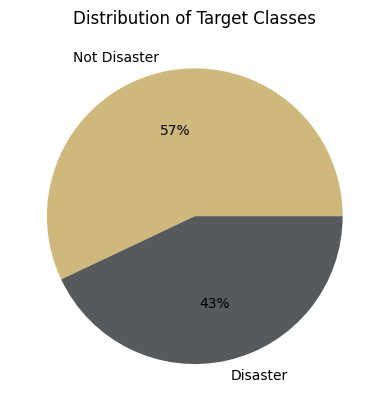

In [6]:
x = train['target'].value_counts()
'''
sns.barplot(x=x.index, y=x.values, palette='cool')
plt.gca().set_ylabel('tweets')
'''
plt.pie(x, labels=['Not Disaster', 'Disaster'], colors = ["#CFB87C", "#565A5C"], autopct='%.0f%%')

plt.title('Distribution of Target Classes')
plt.show()

from the output above, this dataset is banlanced dataset. 

In [7]:
total_rows = len(train)

rows_with_keyword = train['keyword'].notna().sum()

print(f"Total rows: {total_rows}")
print(f"Rows with keyword in train set: {rows_with_keyword} ({rows_with_keyword/total_rows:.2%})")
pos_with_keyword = train[(train['target'] == 1) & (train['keyword'].notna())].shape[0]
pos_total = train[train['target'] == 1].shape[0]

print(f"Positive tweets with keyword in train set : {pos_with_keyword}/{pos_total} "
      f"({pos_with_keyword/pos_total:.2%})")

Total rows: 7613
Rows with keyword in train set: 7552 (99.20%)
Positive tweets with keyword in train set : 3229/3271 (98.72%)


Note that tweets differ from typical text data : they often include links, emojis, typos, escape characters, and garbled text. Therefore, it's essential to clean and preprocess the text before feeding it into a vectorizer.

In [8]:
def clean_text(text):

    text = text.lower()
    
 
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    text = re.sub(r'@\w+', '', text)     
    text = re.sub(r'#\w+', '', text)    
    
    text = re.sub(r'&[a-z]+;', '', text)
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    text = re.sub(r'\d+', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()

    #THE FOLLOWING LINE IS COPY FROM OTHER KAGGLE NOTEBOOK
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r'\\x[0-9A-Fa-f]{2,}|[^\x00-\x8F]+', ' ', text) #\x89Û*
    
    return text


train_clean = train.copy()
test_clean = test.copy()
train_clean.text = train_clean.text.apply(clean_text)
test_clean.text = test_clean.text.apply(clean_text)

print("Train text(words) Length Stat after cleaned: ")
print(train_clean.text.apply(lambda x :  len(x.split())).describe())
print("Test text(words) Length Stat after cleaned: ")
print(test_clean.text.apply(lambda x : len(x.split())).describe())

Train text(words) Length Stat after cleaned: 
count    7613.000000
mean       13.003021
std         5.848734
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
Name: text, dtype: float64
Test text(words) Length Stat after cleaned: 
count    3263.000000
mean       13.010726
std         5.923036
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
Name: text, dtype: float64


In [11]:
train_vocab = set(' '.join(train_clean['text']).split())
test_vocab  = set(' '.join(test_clean['text']).split())

missing_words = test_vocab - train_vocab
print(f"Number of missing words: {len(missing_words)}")
print(f"missing words sample:{list(missing_words)[:100]}")  

Number of missing words: 3025
missing words sample:['ala', 'bharat', 'ikely', 'ain', 'earphones', 'sorta', 'yezidi', 'hardright', 'gawlowski', 'sura', 'antebellum', 'realdepression', 'biltz', 'banging', 'unsurprised', 'reduction', 'northeastern', 'walktrough', 'hollow', 'faded', 'dll', 'husbands', 'terry', 'adjustments', 'sjfeb', 'cottages', 'rural\x89', 'cheyenne', 'hates', 'recode', 'automated', 'shinto', 'nevermind', 'bacup', 'wagyu', 'pakistanexfederal', 'lto', 'hattrick', 'cornwalls', 'forgiveness', 'selffulfilling', 'historically', 'compensation', 'compl', 'sidearm', 'superheroes', 'smoked', 'sank', 'bhyderabadb', 'heenan', 'becauseim', 'rejuvenating', 'fishiest', 'throws', 'indifferent', 'sensible', 'coz', 'aliyu', 'isabel', 'retired', 'dorrett', 'veterinarians', 'kodiak', 'floodwater', 'castes', 'dtom', 'sexthemed', 'fatima', 'disturbed', 'wedne\x89', 'gratuitously', 'soohell', 'norwich', 'mundo', 'socalled', 'recks', 'revelion', 'properties', 'bucket', 'pio', 'qwkd', 'domingue

After a second pass through the test data, we identified 3,025 out-of-vocabulary words terms not present in the training vocabulary. run the cell above, we encountered examples like "blizzards, floodwater", which may represent disaster types not adequately captured by the model. This suggests that the model could struggle to detect emerging or less frequent disaster-related terms, highlighting the need for vocabulary expansion or retraining with more diverse data.

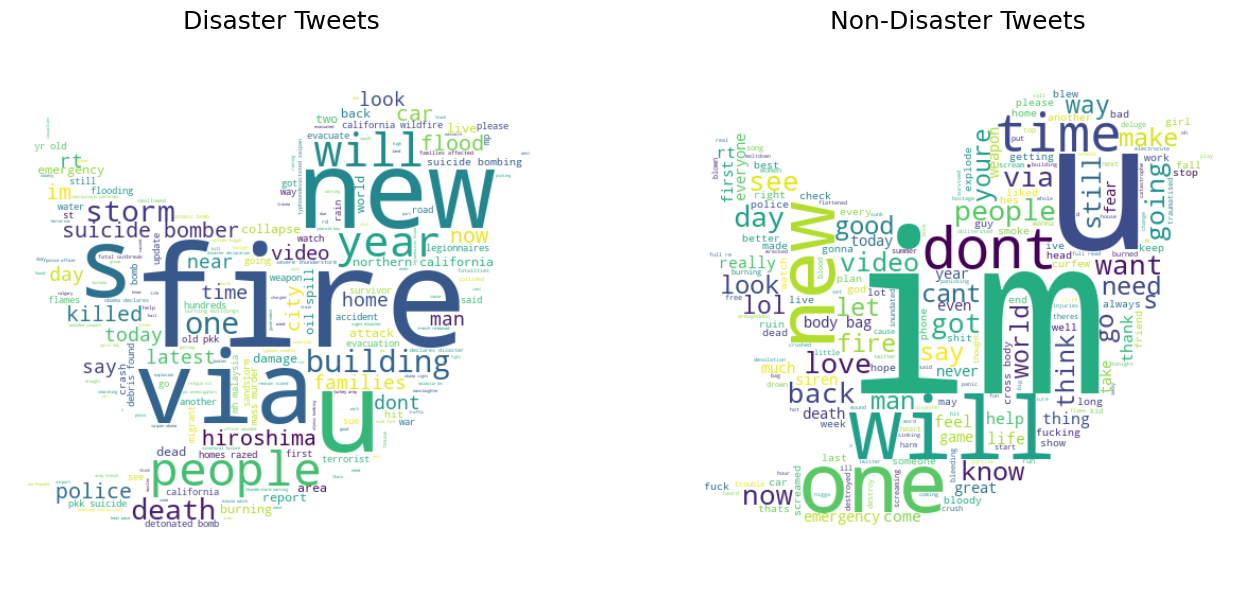

In [47]:
#mask image download link: https://www.kaggle.com/datasets/cartesis07/twittermask
twitter_mask = np.array(Image.open('./twitter_mask3.jpg'))
disaster_text = ' '.join(train_clean[train_clean["target"] == 1].text.tolist())
nondisaster_text = ' '.join(train_clean[train_clean["target"] == 0].text.tolist())


disaster_wc = WordCloud(width=800, height=400, background_color='white', mask=twitter_mask).generate(disaster_text)
nondisaster_wc = WordCloud(width=800, height=400, background_color='white', mask=twitter_mask).generate(nondisaster_text)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(disaster_wc, interpolation='bilinear')
plt.title("Disaster Tweets", fontsize=18)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nondisaster_wc, interpolation='bilinear')
plt.title("Non-Disaster Tweets", fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:

vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(train_clean['text'])
y = train['target']
chi2_vals, p_vals = chi2(X, y)
keywords = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'chi2': chi2_vals,
    'p': p_vals
}).sort_values('chi2', ascending=False)

print(keywords.head(20))

              word        chi2             p
4977           you  232.290287  1.887469e-52
1846            in  199.040595  3.382189e-45
2633            my  151.558115  7.914148e-35
4094       suicide  127.318415  1.582360e-29
517     california  126.308011  2.632787e-29
2071        killed  112.527228  2.738778e-26
1274      families   89.245302  3.487702e-21
1347          fire   84.993243  2.993864e-20
2735      northern   84.955060  3.052242e-20
1702     hiroshima   84.343389  4.158872e-20
2480            mh   83.016889  8.135530e-20
406        bombing   82.519048  1.046567e-19
2175  legionnaires   82.300214  1.169095e-19
57           after   77.830420  1.122776e-18
405         bomber   76.384843  2.334361e-18
3096            pm   74.851152  5.075744e-18
4845      wildfire   74.577042  5.831746e-18
1828            im   72.285390  1.862210e-17
2418            me   70.649812  4.266085e-17
1351         fires   69.935492  6.127594e-17


In [14]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 31

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_clean['text'])


In [16]:
#print(X_train_pad[0])
print(tokenizer.word_index)


{'<OOV>': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'and': 7, 'i': 8, 'is': 9, 'for': 10, 'on': 11, 'you': 12, 'my': 13, 'with': 14, 'it': 15, 'that': 16, 'at': 17, 'by': 18, 'this': 19, 'from': 20, 'are': 21, 'be': 22, 'was': 23, 'have': 24, 'like': 25, 'as': 26, 'me': 27, 'up': 28, 'just': 29, 'but': 30, 'so': 31, '\x89': 32, 'im': 33, 'not': 34, 'your': 35, 'out': 36, 'its': 37, 'all': 38, 'after': 39, 'will': 40, 'when': 41, 'no': 42, 'an': 43, 'has': 44, 'fire': 45, 'if': 46, 'we': 47, 'get': 48, 'new': 49, 'now': 50, 'via': 51, 'more': 52, 'about': 53, 'or': 54, 'what': 55, 'people': 56, 'one': 57, 'he': 58, 'they': 59, 'how': 60, 'dont': 61, 'been': 62, 'over': 63, 'who': 64, 's': 65, 'into': 66, 'do': 67, 'were': 68, 'us': 69, 'video': 70, 'can': 71, 'emergency': 72, 'there': 73, 'disaster': 74, 'police': 75, 'than': 76, 'her': 77, 'would': 78, 'some': 79, 'still': 80, 'his': 81, 'time': 82, 'body': 83, 'news': 84, 'burning': 85, 'back': 86, 'crash': 87, 'suicide': 88, 's

In [17]:
print(tokenizer.word_index['fire'], tokenizer.word_index['fires'], tokenizer.word_index['wildfire'])

45 106 178


After cleaning the data, I noticed a few residual artifacts such as malformed tokens like "word\\x89" and noisy entries like "12910 : maaaaan", and "12917, wm". These likely stem from encoding issues, informal language, or corrupted text, and may require additional preprocessing to ensure clean input for modeling.<br>
Among the 20 most frequent words in the dataset are "fire," "fires," and "wildfire." In some scenarios, these terms may convey the same meaning, but if treated as distinct tokens, this can lead to semantic fragmentation. where the model fails to recognize them as related concepts. This can reduce classification accuracy and limit the model’s ability to generalize across similar disaster types.

In [18]:
#import nltk
#nltk.download('wordnet')
#lemmatizer = WordNetLemmatizer()
#def lemmatize(text):
#    words = text.split()
#    words = [lemmatizer.lemmatize(w) for w in words]
#    return ' '.join(words)

#train_clean.text = train_clean.text.apply(lemmatize)
#test_clean.text = test_clean.text.apply(lemmatize)

#print("Train text(words) Length Stat after cleaned: ")
#print(train_clean.text.apply(lambda x :  len(x.split())).describe())
#print("Test text(words) Length Stat after cleaned: ")
#print(test_clean.text.apply(lambda x : len(x.split())).describe())


tokenizer.fit_on_texts(train_clean['text'])
X_train_seq = tokenizer.texts_to_sequences(train_clean['text'])
X_test_seq = tokenizer.texts_to_sequences(test_clean['text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


y_train = train['target'].values

In [19]:
#X = vectorizer.fit_transform(train_clean['text'])
#y = train['target']
#chi2_vals, p_vals = chi2(X, y)
#keywords = pd.DataFrame({
#    'word': vectorizer.get_feature_names_out(),
#    'chi2': chi2_vals,
#    'p': p_vals
#}).sort_values('chi2', ascending=False)

#print(keywords.head(20))

<h3>Model implement</h3>
Following EDA, we observed that the dataset is relatively small. As a result, it's not necessary to use a deep or overly complex model architecture with many layers, which could lead to overfitting and unnecessary computational overhead.

<h5>Basic models</h5>
Embedding → LSTM(32) → Dropout → Dense
Embedding → GRU(32) → Dropout → Dense
Embedding → BILSTM(32) → Dropout → Dense


In [36]:
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=3,             
    restore_best_weights=True 
)

In [66]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, 64, input_length=X_train_pad.shape[1]),

    LSTM(32, return_sequences=False),# kernel_regularizer=regularizers.l2(0.01),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 31, 64)            640000    
                                                                 
 lstm_10 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 652449 (2.49 MB)
Trainable params: 652449 (2.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.1)#, callbacks=[early_stop]

Epoch 1/10
108/108 [==============================] - 3s 22ms/step - loss: 0.6473 - accuracy: 0.6157 - val_loss: 0.5165 - val_accuracy: 0.7612
Epoch 2/10
108/108 [==============================] - 1s 13ms/step - loss: 0.4053 - accuracy: 0.8362 - val_loss: 0.4579 - val_accuracy: 0.7861
Epoch 3/10
108/108 [==============================] - 1s 11ms/step - loss: 0.2804 - accuracy: 0.8955 - val_loss: 0.5304 - val_accuracy: 0.7835
Epoch 4/10
108/108 [==============================] - 1s 11ms/step - loss: 0.2181 - accuracy: 0.9242 - val_loss: 0.5376 - val_accuracy: 0.7808
Epoch 5/10
108/108 [==============================] - 1s 11ms/step - loss: 0.1691 - accuracy: 0.9441 - val_loss: 0.6273 - val_accuracy: 0.7756
Epoch 6/10
108/108 [==============================] - 1s 11ms/step - loss: 0.1374 - accuracy: 0.9566 - val_loss: 0.6747 - val_accuracy: 0.7480
Epoch 7/10
108/108 [==============================] - 1s 11ms/step - loss: 0.1334 - accuracy: 0.9553 - val_loss: 0.8586 - val_accuracy: 0.7428

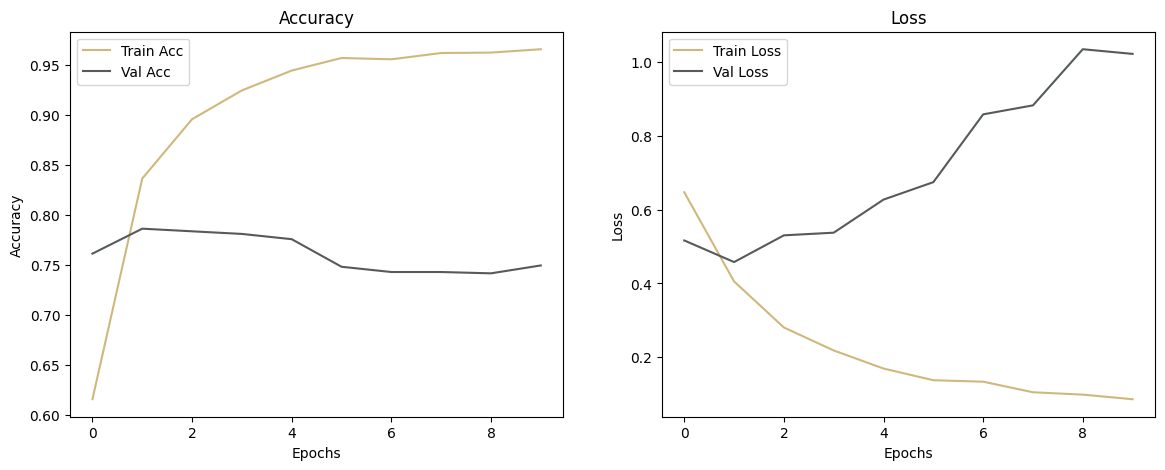

In [77]:
def plot_training_curves(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # "#CFB87C", "#565A5C"
    axes[0].plot(history.history['accuracy'], label='Train Acc', color = '#CFB87C')
    axes[0].plot(history.history['val_accuracy'], label='Val Acc', color = '#565A5C')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()


    axes[1].plot(history.history['loss'], label='Train Loss', color = '#CFB87C')
    axes[1].plot(history.history['val_loss'], label='Val Loss', color = '#565A5C')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.show()

plot_training_curves(history)

238/238 [==============================] - 1s 2ms/step
(7613,) (7613, 1)


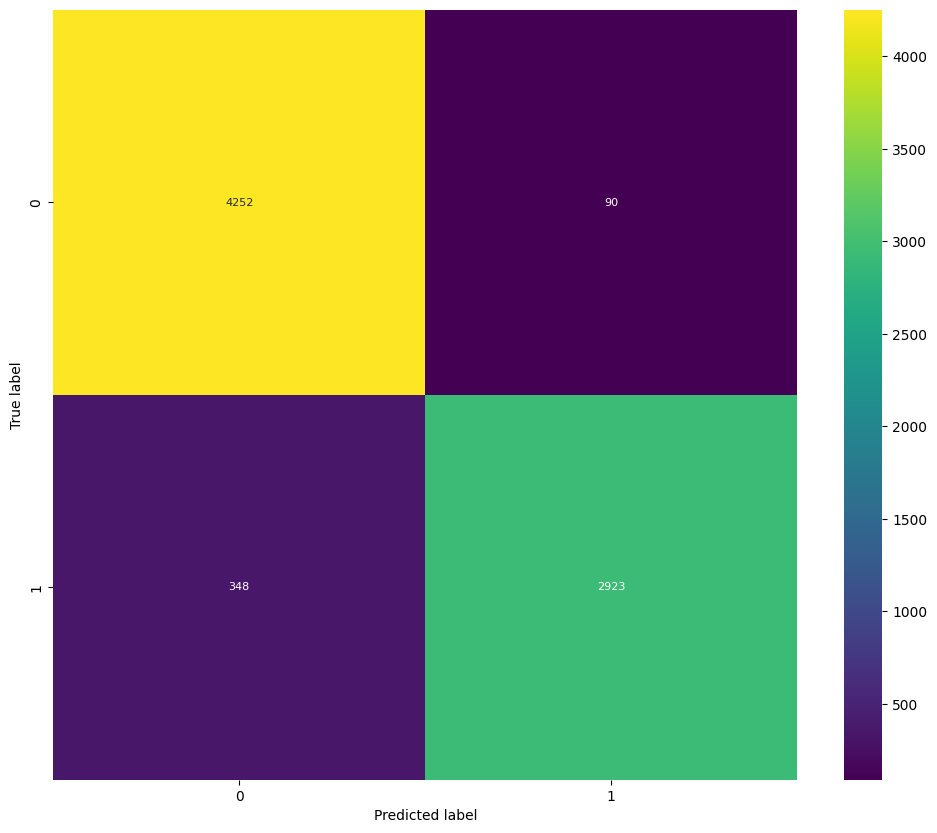

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4342
           1       0.97      0.89      0.93      3271

    accuracy                           0.94      7613
   macro avg       0.95      0.94      0.94      7613
weighted avg       0.94      0.94      0.94      7613



In [69]:
pred_probs = model.predict(X_train_pad)
preds = (pred_probs > 0.5).astype(int)

print(y_train.shape, preds.shape)
conf_matrix = confusion_matrix(y_train, preds)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", 
            annot_kws={"size":8})  
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

print(classification_report(y_train, preds))


In [260]:
pred_probs = model.predict(X_test_pad)
preds = (pred_probs > 0.5).astype(int)


102/102 [==============================] - 1s 5ms/step


In [262]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = preds
submission.to_csv('rnn_submission1.csv', index=False)

In [70]:
model_gru = Sequential([
    Embedding(MAX_VOCAB_SIZE, 64, input_length=X_train_pad.shape[1]),
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_gru = model_gru.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.1)


Epoch 1/10
108/108 [==============================] - 3s 22ms/step - loss: 0.6837 - accuracy: 0.5712 - val_loss: 0.6954 - val_accuracy: 0.5341
Epoch 2/10
108/108 [==============================] - 1s 12ms/step - loss: 0.6833 - accuracy: 0.5741 - val_loss: 0.6942 - val_accuracy: 0.5341
Epoch 3/10
108/108 [==============================] - 1s 11ms/step - loss: 0.6828 - accuracy: 0.5744 - val_loss: 0.6910 - val_accuracy: 0.5341
Epoch 4/10
108/108 [==============================] - 1s 11ms/step - loss: 0.5761 - accuracy: 0.6925 - val_loss: 0.4868 - val_accuracy: 0.7743
Epoch 5/10
108/108 [==============================] - 1s 10ms/step - loss: 0.3586 - accuracy: 0.8586 - val_loss: 0.4763 - val_accuracy: 0.7756
Epoch 6/10
108/108 [==============================] - 1s 10ms/step - loss: 0.2567 - accuracy: 0.9096 - val_loss: 0.5288 - val_accuracy: 0.7638
Epoch 7/10
108/108 [==============================] - 1s 10ms/step - loss: 0.1894 - accuracy: 0.9380 - val_loss: 0.5904 - val_accuracy: 0.7756

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 31, 64)            640000    
                                                                 
 gru_4 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 649441 (2.48 MB)
Trainable params: 649441 (2.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


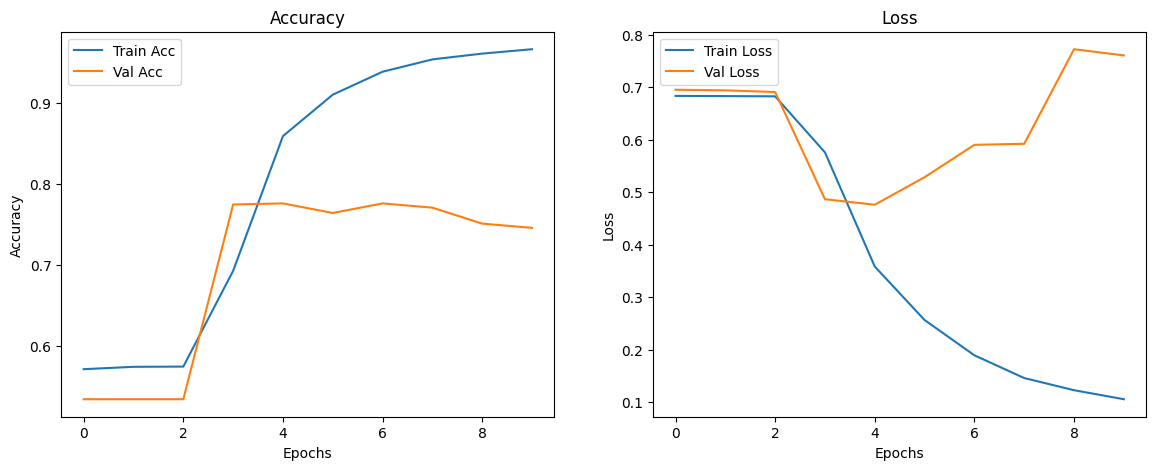

In [71]:
model_gru.summary()
plot_training_curves(history_gru)

238/238 [==============================] - 1s 2ms/step
(7613,) (7613, 1)


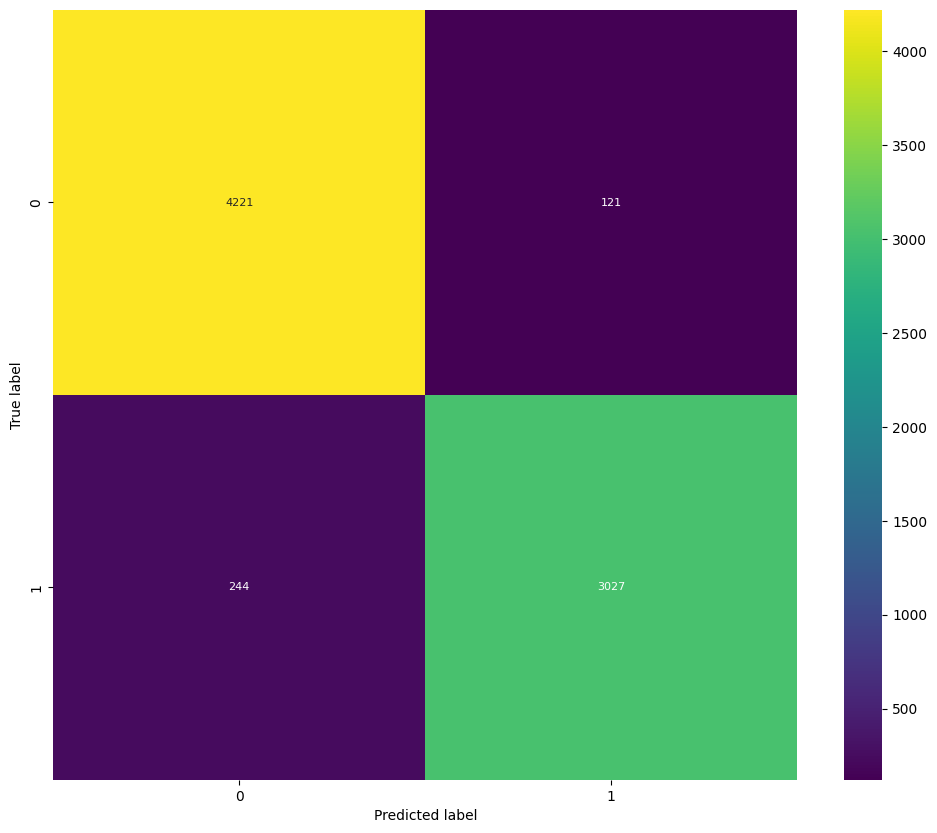

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4342
           1       0.96      0.93      0.94      3271

    accuracy                           0.95      7613
   macro avg       0.95      0.95      0.95      7613
weighted avg       0.95      0.95      0.95      7613



In [72]:
pred_probs_gru = model_gru.predict(X_train_pad)
preds_gru = (pred_probs_gru > 0.5).astype(int)

print(y_train.shape, preds_gru.shape)
conf_matrix = confusion_matrix(y_train, preds_gru)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", 
            annot_kws={"size":8})  
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

print(classification_report(y_train, preds_gru))


In [180]:
#submission = pd.read_csv('sample_submission1.csv')
pred_probs_gru = model_gru.predict(X_test_pad)
preds_gru = (pred_probs_gru > 0.5).astype(int)
submission['target'] = preds_gru
submission.to_csv('gru_submission.csv1', index=False)

102/102 [==============================] - 0s 3ms/step


In [74]:
model_bi_lstm = Sequential([
    Embedding(MAX_VOCAB_SIZE, 64, input_length=X_train_pad.shape[1]),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bi_lstm = model_bi_lstm.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.1)



Epoch 1/10
108/108 [==============================] - 6s 31ms/step - loss: 0.6127 - accuracy: 0.6570 - val_loss: 0.5053 - val_accuracy: 0.7743
Epoch 2/10
108/108 [==============================] - 2s 19ms/step - loss: 0.3894 - accuracy: 0.8422 - val_loss: 0.4491 - val_accuracy: 0.7861
Epoch 3/10
108/108 [==============================] - 2s 17ms/step - loss: 0.2675 - accuracy: 0.9035 - val_loss: 0.4667 - val_accuracy: 0.7992
Epoch 4/10
108/108 [==============================] - 2s 16ms/step - loss: 0.2035 - accuracy: 0.9314 - val_loss: 0.5482 - val_accuracy: 0.7638
Epoch 5/10
108/108 [==============================] - 2s 16ms/step - loss: 0.1590 - accuracy: 0.9460 - val_loss: 0.5835 - val_accuracy: 0.7559
Epoch 6/10
108/108 [==============================] - 2s 16ms/step - loss: 0.1308 - accuracy: 0.9533 - val_loss: 0.7384 - val_accuracy: 0.7428
Epoch 7/10
108/108 [==============================] - 2s 16ms/step - loss: 0.1096 - accuracy: 0.9634 - val_loss: 0.8535 - val_accuracy: 0.7231

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 31, 64)            640000    
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 664897 (2.54 MB)
Trainable params: 664897 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


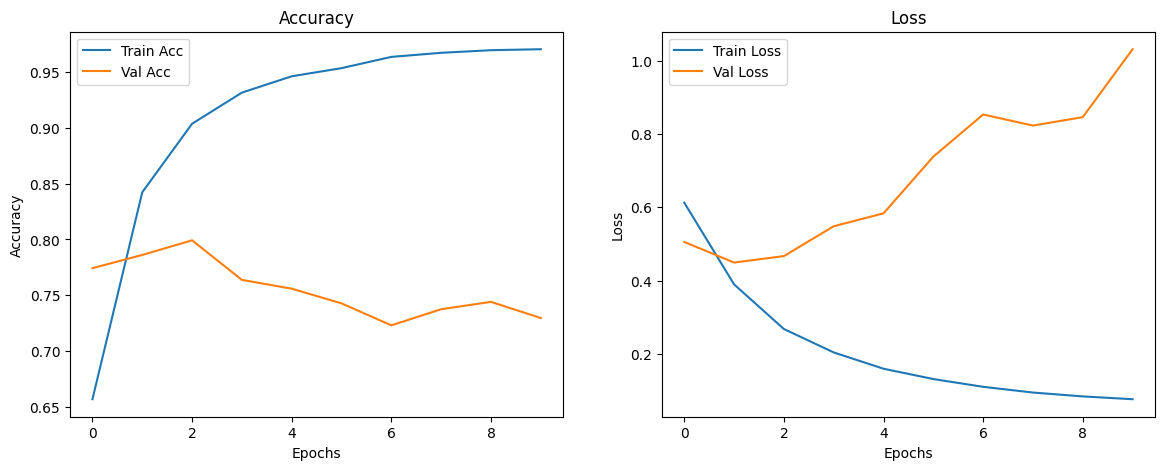

In [75]:
model_bi_lstm.summary()

plot_training_curves(history_bi_lstm)

238/238 [==============================] - 1s 4ms/step
(7613,) (7613, 1)


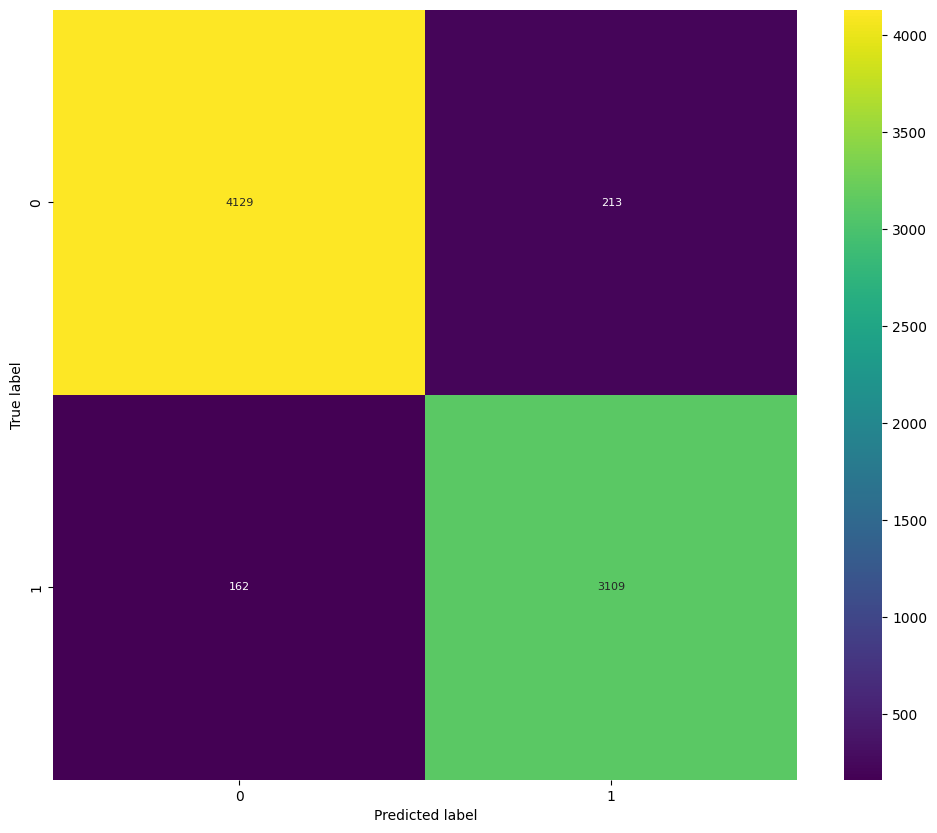

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      4342
           1       0.94      0.95      0.94      3271

    accuracy                           0.95      7613
   macro avg       0.95      0.95      0.95      7613
weighted avg       0.95      0.95      0.95      7613



In [76]:
pred_probs_bi_lstm = model_bi_lstm.predict(X_train_pad)
preds_bi_lstm = (pred_probs_bi_lstm > 0.5).astype(int)

print(y_train.shape, preds_bi_lstm.shape)
conf_matrix = confusion_matrix(y_train, preds_bi_lstm)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", 
            annot_kws={"size":8})  
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

print(classification_report(y_train, preds_bi_lstm))

In [184]:
pred_probs_bi_lstm = model_bi_lstm.predict(X_test_pad)
preds_bi_lstm = (pred_probs_bi_lstm > 0.5).astype(int)
submission['target'] = preds_bi_lstm
submission.to_csv('bi_lstm_submission1.csv', index=False)

102/102 [==============================] - 1s 5ms/step


<h5>LSTM</h5>

	•	Training accuracy rises steadily to ~96%
	•	Validation accuracy peaks around ~78–79%, then declines
	•	Validation loss increases rapidly after epoch 3
    •	Struggles slightly with recall on disaster tweets (class 1)
  
<h5>GRU</h5>

	•	Training accuracy increases to ~96%
	•	Validation accuracy peaks near ~77–78%
	•	Validation loss increases slower than LSTM
 
<h5>Bidirectional LSTM</h5>

	•	Training accuracy increases to ~97%
	•	Validation accuracy improves up to ~80% (best among the three)
	•	Then declines from epoch 4 onward
	•	Best recall for disaster tweets (class 1)

After submitting the prediction file to Kaggle, it became evident that the baseline models were significantly overfitting the training data. Among all the models tested, the GRU-based model demonstrated the best generalization performance on the test set, making it the most effective approach for this task.

<h3>Model Improvement Using GloVe</h3>
To enhance model performance, I integrated pre-trained GloVe embeddings—specifically glove.twitter.27B.100d—for text representation. This adjustment helped mitigate overfitting, as evidenced by smoother and more stable training and validation accuracy/loss curves.
Although the model's accuracy and F1 score were slightly lower than those of the baseline models during local evaluation, the Kaggle submission score improved, indicating better generalization to unseen data. Among the three models tested, the GRU-based model continued to deliver the best overall performance.

In [29]:
glove_path = "../glove/glove.twitter.27B.100d.txt"
embeddings_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Found {len(embeddings_index)} word vectors.")

Found 1193514 word vectors.


In [30]:
embedding_dim = 100 
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, embedding_dim))
word_index = tokenizer.word_index
for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [31]:
glovemodel = Sequential([
    Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=X_train_pad.shape[1],
        trainable=False  
    ),
    LSTM(64, return_sequences=True),#  kernel_regularizer=regularizers.l2(0.01),
    Dropout(0.6),
    LSTM(64, return_sequences=False),# kernel_regularizer=regularizers.l2(0.01),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

glovemodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

glovemodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 100)           1000000   
                                                                 
 lstm_2 (LSTM)               (None, 31, 64)            42240     
                                                                 
 dropout_3 (Dropout)         (None, 31, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1075329 (4.10 MB)
Trainable params: 7532

In [38]:
history = glovemodel.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.1)#, callbacks=[early_stop]

Epoch 1/10
108/108 [==============================] - 2s 14ms/step - loss: 0.2967 - accuracy: 0.8810 - val_loss: 0.5074 - val_accuracy: 0.7625
Epoch 2/10
108/108 [==============================] - 1s 14ms/step - loss: 0.3095 - accuracy: 0.8739 - val_loss: 0.5231 - val_accuracy: 0.7756
Epoch 3/10
108/108 [==============================] - 1s 13ms/step - loss: 0.2732 - accuracy: 0.8934 - val_loss: 0.4959 - val_accuracy: 0.8018
Epoch 4/10
108/108 [==============================] - 1s 13ms/step - loss: 0.2680 - accuracy: 0.8986 - val_loss: 0.5976 - val_accuracy: 0.7927
Epoch 5/10
108/108 [==============================] - 1s 13ms/step - loss: 0.2506 - accuracy: 0.9054 - val_loss: 0.5538 - val_accuracy: 0.7979
Epoch 6/10
108/108 [==============================] - 1s 13ms/step - loss: 0.2415 - accuracy: 0.9130 - val_loss: 0.7089 - val_accuracy: 0.7756
Epoch 7/10
108/108 [==============================] - 1s 14ms/step - loss: 0.2195 - accuracy: 0.9223 - val_loss: 0.6884 - val_accuracy: 0.7795

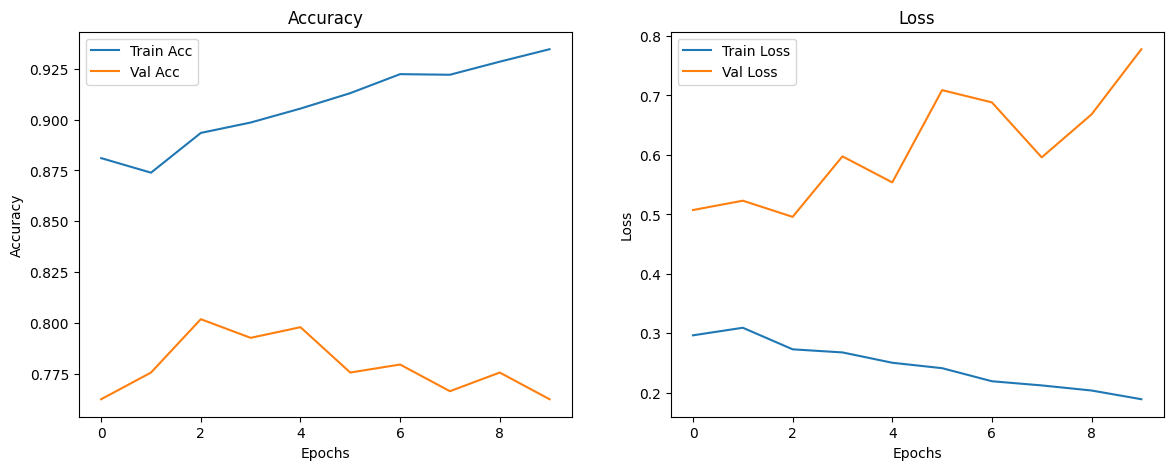

In [39]:


plot_training_curves(history)

238/238 [==============================] - 1s 3ms/step
(7613,) (7613, 1)


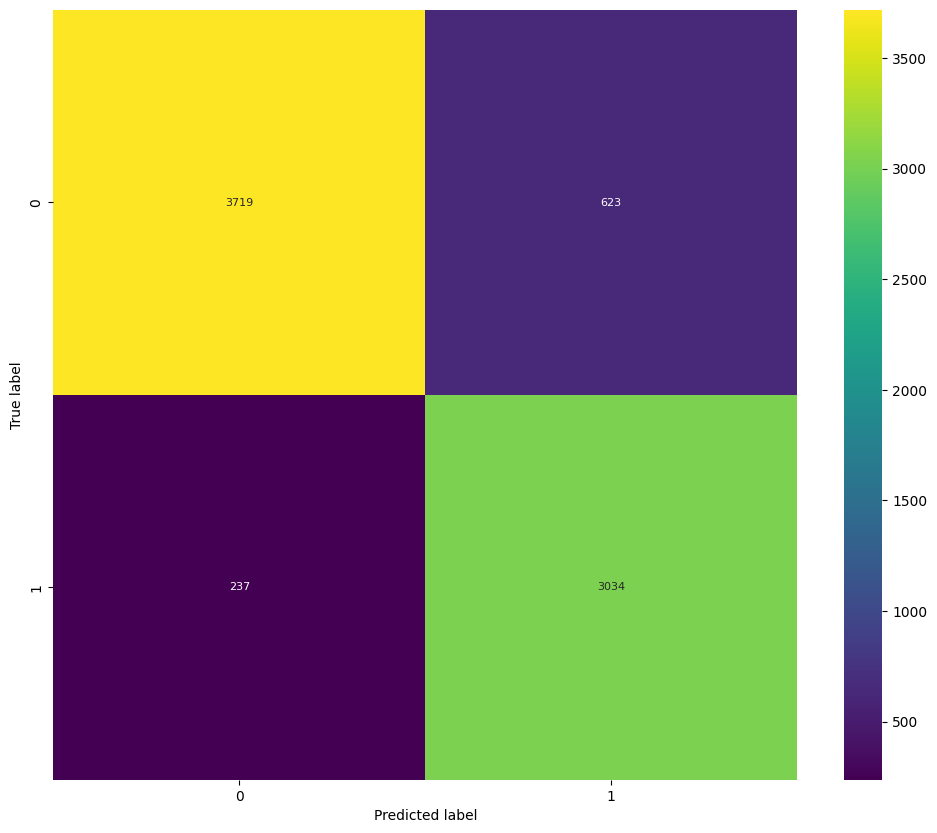

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      4342
           1       0.83      0.93      0.88      3271

    accuracy                           0.89      7613
   macro avg       0.88      0.89      0.89      7613
weighted avg       0.89      0.89      0.89      7613



In [40]:
pred_probs = glovemodel.predict(X_train_pad)
preds = (pred_probs > 0.5).astype(int)

print(y_train.shape, preds.shape)
conf_matrix = confusion_matrix(y_train, preds)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", 
            annot_kws={"size":8})  
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

print(classification_report(y_train, preds))

In [318]:
pred_probs = glovemodel.predict(X_test_pad)
preds = (pred_probs > 0.5).astype(int)
submission['target'] = preds
submission.to_csv('rnn_submission_glove.csv', index=False)

102/102 [==============================] - 1s 5ms/step


Epoch 1/10
108/108 [==============================] - 4s 19ms/step - loss: 0.6023 - accuracy: 0.6589 - val_loss: 0.4596 - val_accuracy: 0.7861
Epoch 2/10
108/108 [==============================] - 1s 13ms/step - loss: 0.4553 - accuracy: 0.8008 - val_loss: 0.4215 - val_accuracy: 0.8058
Epoch 3/10
108/108 [==============================] - 1s 13ms/step - loss: 0.4336 - accuracy: 0.8116 - val_loss: 0.4291 - val_accuracy: 0.7927
Epoch 4/10
108/108 [==============================] - 1s 13ms/step - loss: 0.4249 - accuracy: 0.8190 - val_loss: 0.4118 - val_accuracy: 0.8215
Epoch 5/10
108/108 [==============================] - 1s 13ms/step - loss: 0.4110 - accuracy: 0.8241 - val_loss: 0.4131 - val_accuracy: 0.8228
Epoch 6/10
108/108 [==============================] - 1s 13ms/step - loss: 0.3937 - accuracy: 0.8375 - val_loss: 0.4184 - val_accuracy: 0.8123
Epoch 7/10
108/108 [==============================] - 1s 13ms/step - loss: 0.3808 - accuracy: 0.8472 - val_loss: 0.4152 - val_accuracy: 0.8215

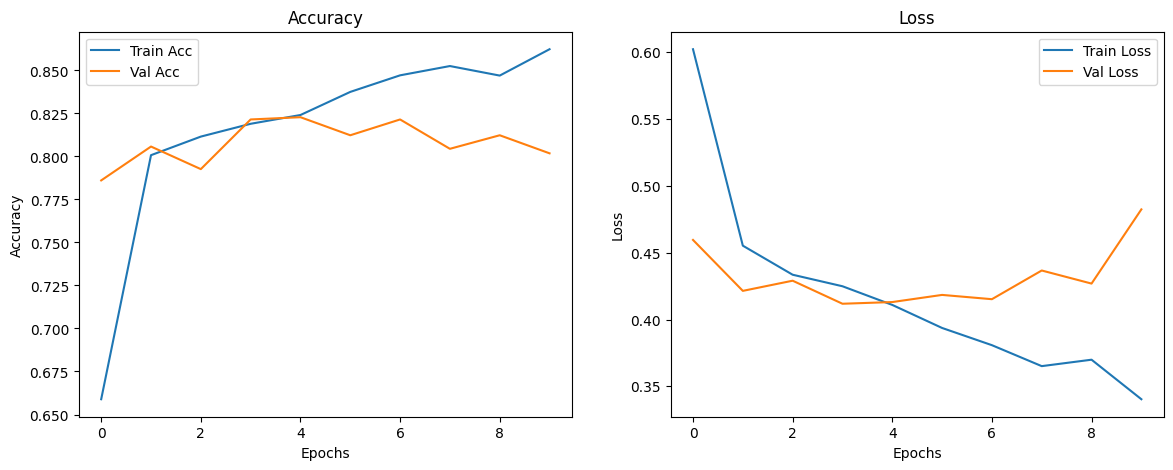

In [41]:
model_gru = Sequential([
    Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=X_train_pad.shape[1],
        trainable=False  
    ),
    GRU(64, return_sequences=True),
    Dropout(0.3),
    GRU(64, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_gru = model_gru.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.1)
plot_training_curves(history_gru)

238/238 [==============================] - 1s 3ms/step
(7613,) (7613, 1)


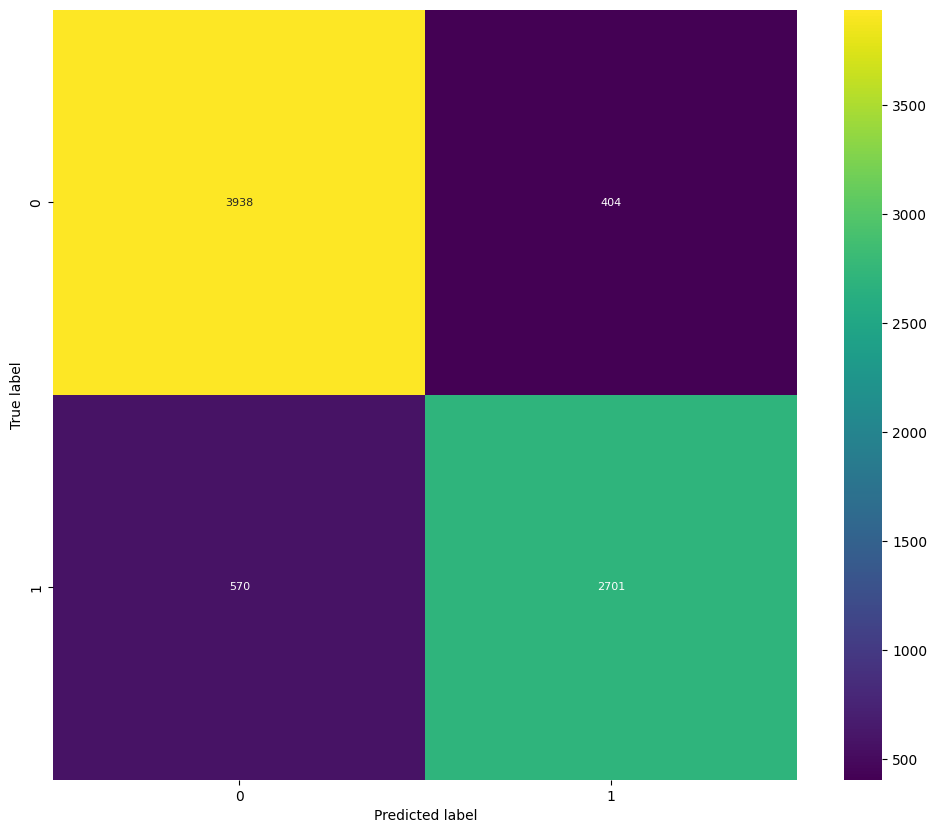

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4342
           1       0.87      0.83      0.85      3271

    accuracy                           0.87      7613
   macro avg       0.87      0.87      0.87      7613
weighted avg       0.87      0.87      0.87      7613



In [42]:
pred_probs_gru = model_gru.predict(X_train_pad)
preds_gru = (pred_probs_gru > 0.5).astype(int)

print(y_train.shape, preds_gru.shape)
conf_matrix = confusion_matrix(y_train, preds_gru)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", 
            annot_kws={"size":8})  
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

print(classification_report(y_train, preds_gru))


In [328]:
pred_probs_gru = model_gru.predict(X_test_pad)
preds_gru = (pred_probs_gru > 0.5).astype(int)
submission['target'] = preds_gru
submission.to_csv('gru_submission_glove.csv', index=False)

102/102 [==============================] - 0s 3ms/step


Epoch 1/10
108/108 [==============================] - 7s 37ms/step - loss: 0.4913 - accuracy: 0.7694 - val_loss: 0.4400 - val_accuracy: 0.8071
Epoch 2/10
108/108 [==============================] - 3s 28ms/step - loss: 0.4378 - accuracy: 0.8057 - val_loss: 0.4288 - val_accuracy: 0.8150
Epoch 3/10
108/108 [==============================] - 3s 28ms/step - loss: 0.4240 - accuracy: 0.8145 - val_loss: 0.4235 - val_accuracy: 0.8097
Epoch 4/10
108/108 [==============================] - 3s 28ms/step - loss: 0.4098 - accuracy: 0.8183 - val_loss: 0.4344 - val_accuracy: 0.7874
Epoch 5/10
108/108 [==============================] - 3s 28ms/step - loss: 0.4038 - accuracy: 0.8221 - val_loss: 0.4289 - val_accuracy: 0.7940
Epoch 6/10
108/108 [==============================] - 3s 28ms/step - loss: 0.3867 - accuracy: 0.8318 - val_loss: 0.4254 - val_accuracy: 0.8176
Epoch 7/10
108/108 [==============================] - 3s 28ms/step - loss: 0.3682 - accuracy: 0.8409 - val_loss: 0.4362 - val_accuracy: 0.8097

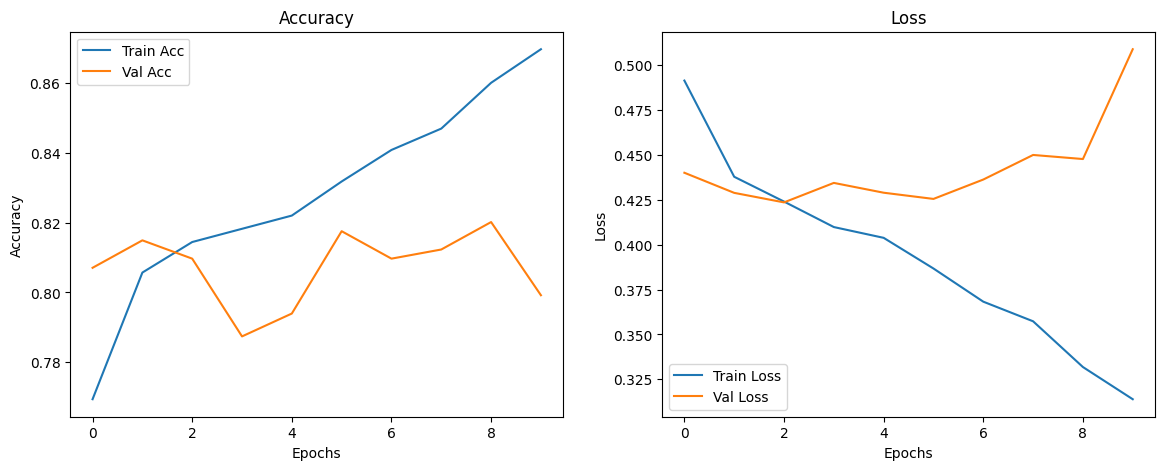

In [43]:
model_bi_lstm = Sequential([
    Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=X_train_pad.shape[1],
        trainable=False  
    ),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_bi_lstm = model_bi_lstm.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.1)
plot_training_curves(history_bi_lstm)

238/238 [==============================] - 3s 9ms/step
(7613,) (7613, 1)


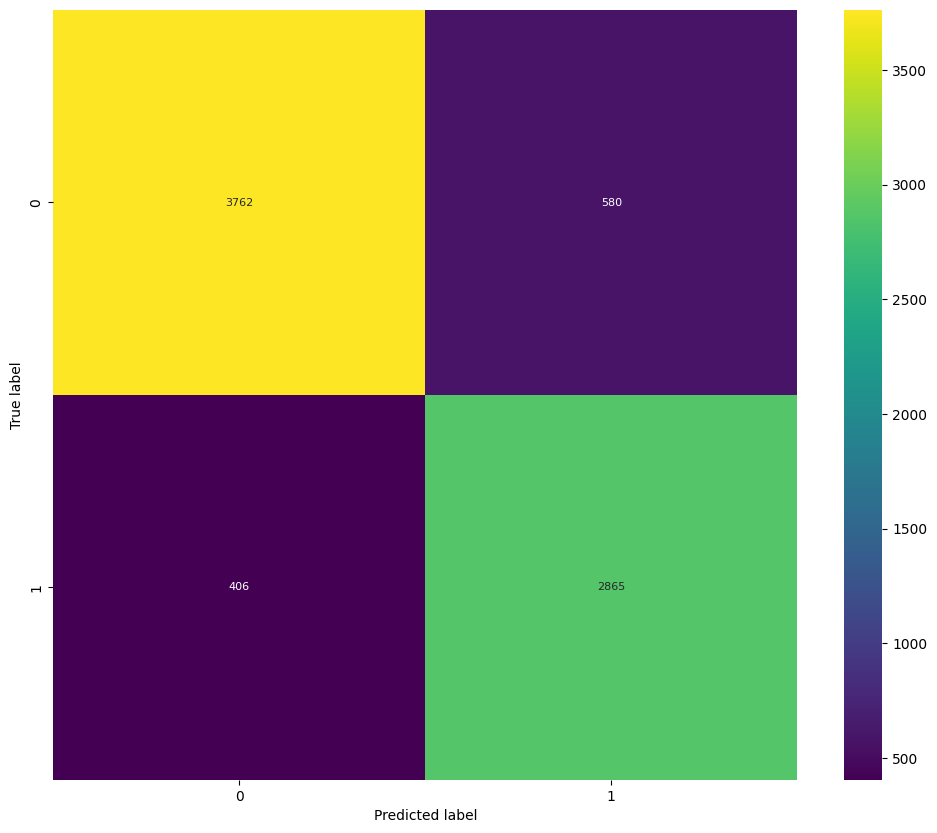

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4342
           1       0.83      0.88      0.85      3271

    accuracy                           0.87      7613
   macro avg       0.87      0.87      0.87      7613
weighted avg       0.87      0.87      0.87      7613



In [44]:
pred_probs_bi_lstm = model_bi_lstm.predict(X_train_pad)
preds_bi_lstm = (pred_probs_bi_lstm > 0.5).astype(int)

print(y_train.shape, preds_bi_lstm.shape)
conf_matrix = confusion_matrix(y_train, preds_bi_lstm)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", 
            annot_kws={"size":8})  
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

print(classification_report(y_train, preds_bi_lstm))

In [327]:
pred_probs_bi_lstm = model_bi_lstm.predict(X_test_pad)
preds_bi_lstm = (pred_probs_bi_lstm > 0.5).astype(int)
submission['target'] = preds_bi_lstm
submission.to_csv('bi_lstm_submission_glove.csv', index=False)

102/102 [==============================] - 1s 10ms/step


<h3>Conclusion</h3>
Although all three models showed lower accuracy and F1 scores on the internal validation set after introducing GloVe embeddings, their performance on the Kaggle test set significantly improved. This indicates that GloVe reduced overfitting by providing richer, noise-resistant word representations, improving generalization to unseen tweets. The flatter training curves and narrower train–val gap further confirm the improved stability and robustness of the GloVe-enhanced models.